In [1]:
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract(
    "./Main_27.04.2023.apkg", filter_out_suspended_cards, filter_out_flags
)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False
)
optimizer.define_model()
optimizer.pretrain(verbose=False)

Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/30507 [00:00<?, ?it/s]

Trainset saved.


[]

In [2]:
from torch import Tensor, nn
import torch
from statsmodels.nonparametric.smoothers_lowess import lowess


class ICILoss(nn.Module):
    def __init__(self):
        super(ICILoss, self).__init__()
        # self.loss_fn = nn.L1Loss(reduce="None")
        self.loss_fn = nn.MSELoss(reduce="None")

    def forward(self, predictions: Tensor, labels: Tensor) -> Tensor:
        observation = lowess(
            labels.detach().numpy(),
            predictions.detach().numpy(),
            it=0,
            delta=0.01
            * (max(predictions.detach().numpy()) - min(predictions.detach().numpy())),
            return_sorted=False,
        )
        observation = torch.as_tensor(observation, dtype=torch.float32)
        # return self.loss_fn(predictions, observation)
        return torch.sqrt(self.loss_fn(predictions, observation))

  0%|          | 0/247973 [00:00<?, ?it/s]

train:   0%|          | 0/3861040 [00:00<?, ?it/s]

iteration: 384675
w: [0.2721, 0.2715, 1.1176, 99.9986, 7.1916, 0.537, 1.4635, 0.001, 1.5472, 0.1229, 1.0209, 1.9383, 0.1118, 0.2947, 2.2684, 0.234, 2.9919, 0.5091, 0.6674]
iteration: 769001
w: [0.2773, 0.2752, 1.1204, 99.9982, 7.188, 0.5402, 1.4652, 0.001, 1.5492, 0.1265, 1.0232, 1.9376, 0.1131, 0.2939, 2.2674, 0.2373, 2.9948, 0.5021, 0.6727]
iteration: 1153676
w: [0.282, 0.2793, 1.1231, 99.9973, 7.1843, 0.5436, 1.4669, 0.001, 1.5515, 0.1289, 1.0257, 1.937, 0.1144, 0.2932, 2.2665, 0.2402, 2.9974, 0.4961, 0.6773]
iteration: 1538002
w: [0.2854, 0.2818, 1.1247, 99.9965, 7.1818, 0.5458, 1.469, 0.001, 1.5526, 0.1316, 1.027, 1.9361, 0.1157, 0.2922, 2.2654, 0.2418, 2.9991, 0.4907, 0.681]
iteration: 1922677
w: [0.2881, 0.2844, 1.1264, 99.996, 7.18, 0.5475, 1.4709, 0.001, 1.5534, 0.1337, 1.0279, 1.9356, 0.1167, 0.2915, 2.2647, 0.2431, 3.0004, 0.4865, 0.6839]
iteration: 2307003
w: [0.2905, 0.2863, 1.1277, 99.9957, 7.1782, 0.5492, 1.4719, 0.001, 1.5546, 0.1349, 1.0292, 1.9356, 0.117, 0.2915, 2.26

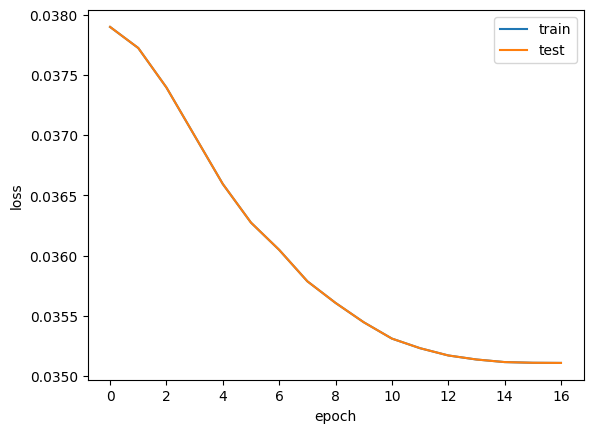

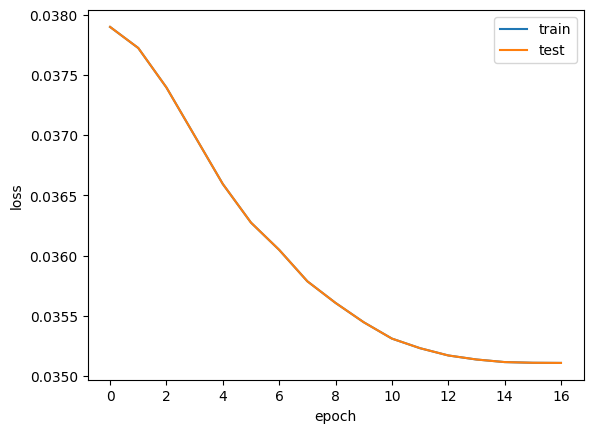

In [3]:
from fsrs_optimizer import Trainer, lineToTensor

lr: float = 1e-4
n_epoch: int = 16
n_splits: int = 2
batch_size: int = 4096
verbose: bool = True

dataset = optimizer.dataset
dataset["tensor"] = dataset.progress_apply(
    lambda x: lineToTensor(list(zip([x["t_history"]], [x["r_history"]]))[0]),
    axis=1,
)
dataset["group"] = dataset["r_history"] + dataset["t_history"]

trainer = Trainer(
    dataset,
    dataset,
    optimizer.init_w,
    n_epoch=n_epoch,
    lr=lr,
    batch_size=batch_size,
)
trainer.loss_fn = ICILoss()
optimizer.w = trainer.train(verbose=verbose)
trainer.plot()

Loss before training: 0.4272
Loss after training: 0.4175
RMSE(bins): 0.0420

Last rating: 1
RMSE(bins): 0.0635

Last rating: 2
RMSE(bins): 0.0472

Last rating: 3
RMSE(bins): 0.0419

Last rating: 4
RMSE(bins): 0.0512


{'all': {'R-squared': 0.8479154769746009,
  'MAE': 0.022882292040824537,
  'ICI': 0.021954558844473615,
  'E50': 0.01524565320017246,
  'E90': 0.03570024344986378,
  'EMax': 0.3335071951037618,
  'RMSE(bins)': 0.04200476553507605,
  'AUC': 0.6844462202597422},
 1: {'R-squared': 0.3854067954355902,
  'MAE': 0.06651321218901167,
  'ICI': 0.06433537889170317,
  'E50': 0.06437141190318496,
  'E90': 0.09489662466695703,
  'EMax': 0.33023603423031256,
  'RMSE(bins)': 0.06351464189595123,
  'AUC': 0.665306571176453},
 2: {'R-squared': 0.7626919088322768,
  'MAE': 0.04019816208820556,
  'ICI': 0.03732079103044913,
  'E50': 0.03463688456951314,
  'E90': 0.041120513374906076,
  'EMax': 0.34446404544465814,
  'RMSE(bins)': 0.04721234502374258,
  'AUC': 0.6724137296768364},
 3: {'R-squared': 0.914922316386476,
  'MAE': 0.014115343422075684,
  'ICI': 0.012139655311576045,
  'E50': 0.006740660204406668,
  'E90': 0.021256006587042242,
  'EMax': 0.24609857984815434,
  'RMSE(bins)': 0.04188243279567508

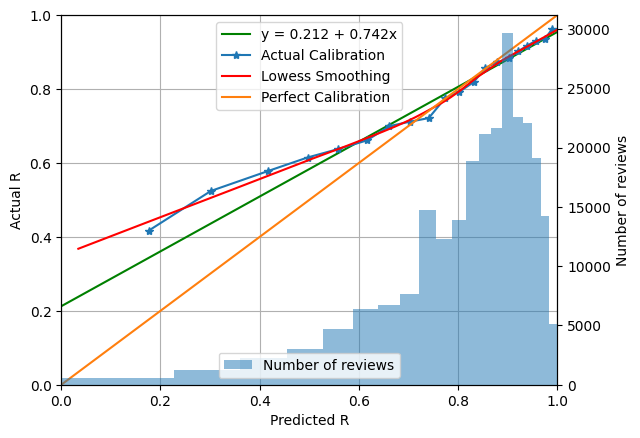

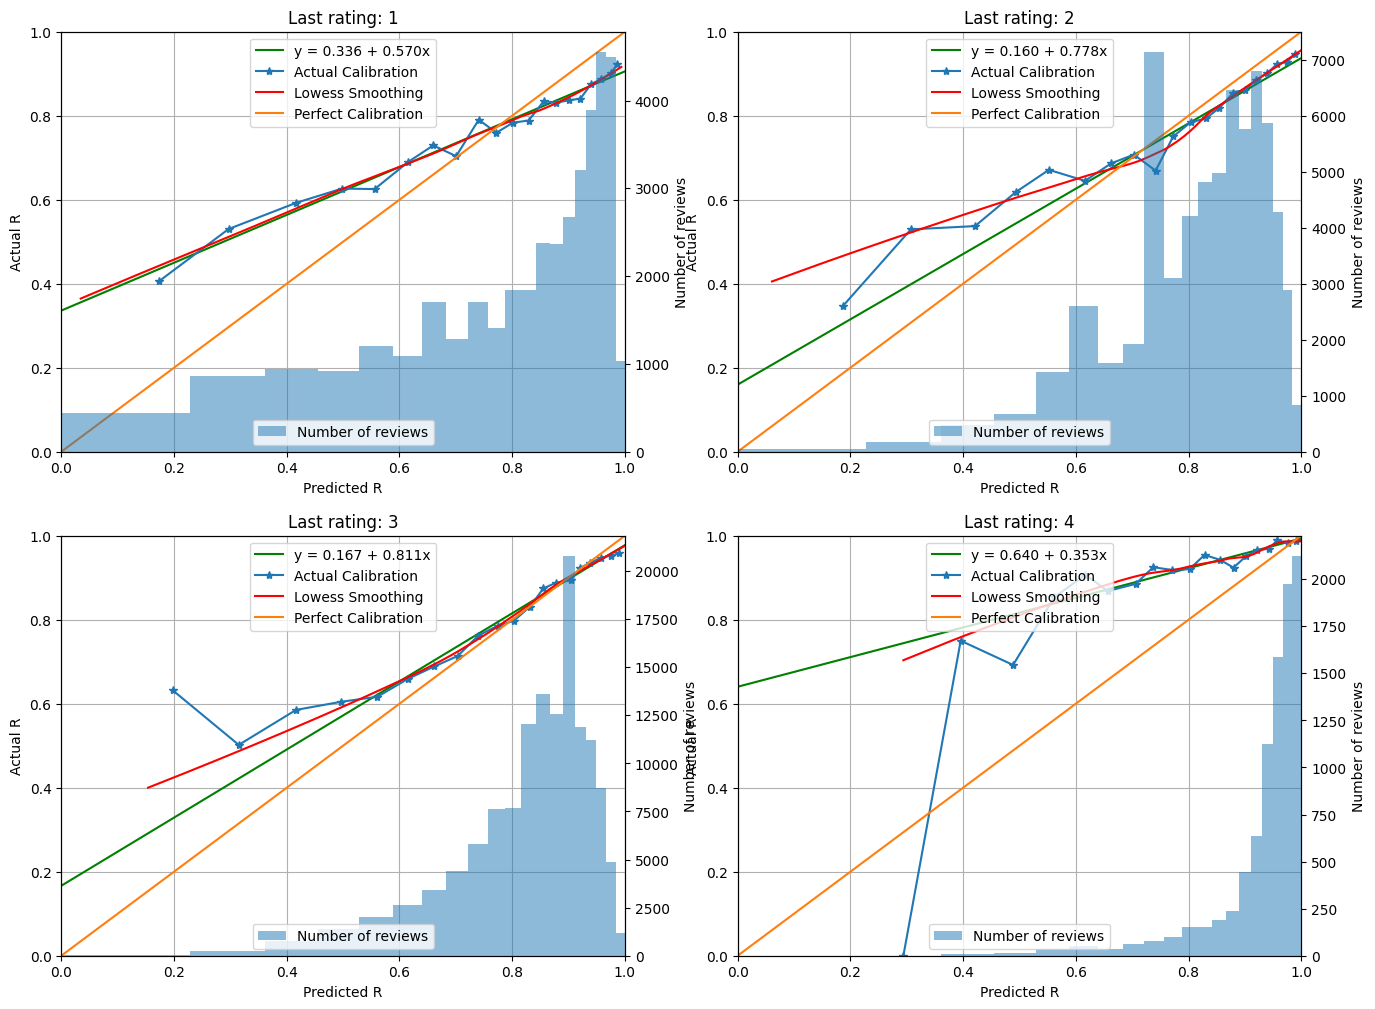

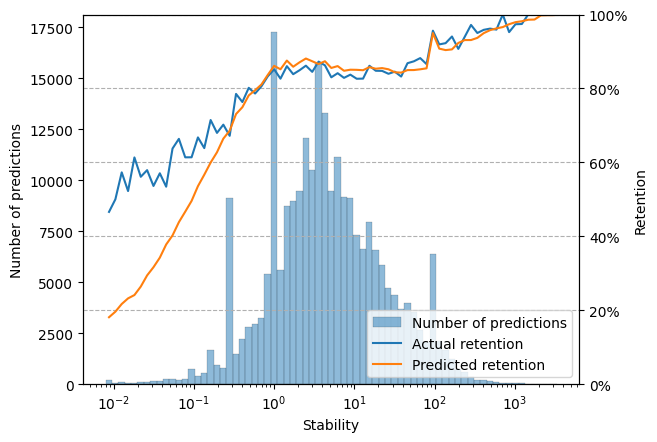

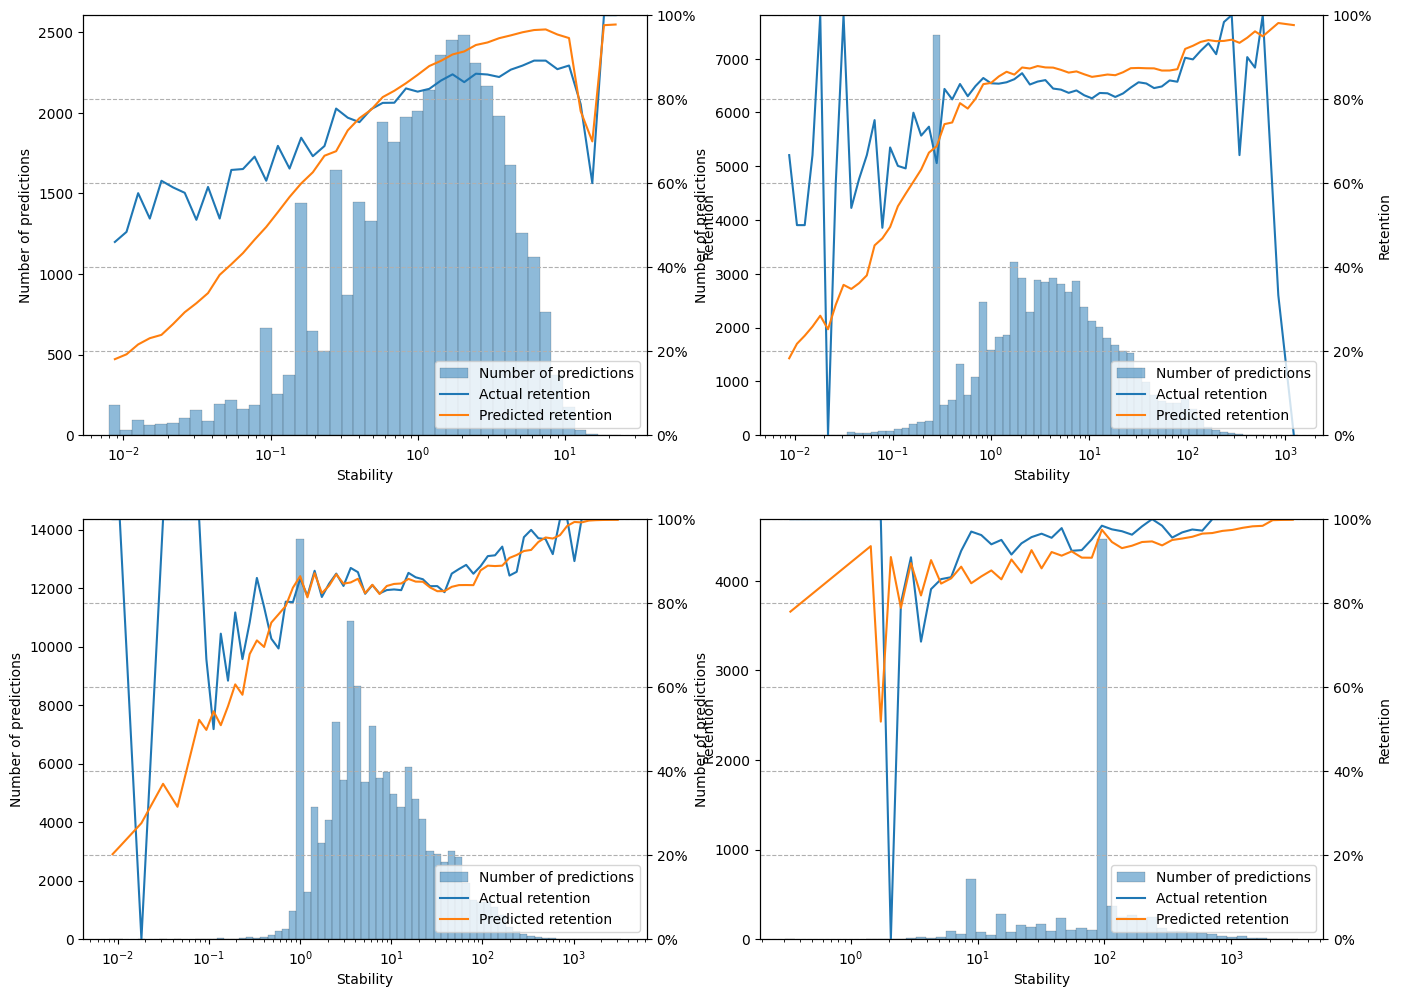

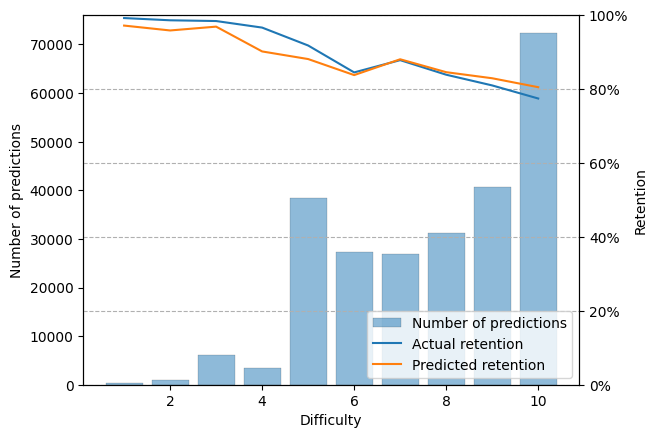

In [4]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")
metrics, figures = optimizer.calibration_graph()
metrics

train:   0%|          | 0/1206575 [00:00<?, ?it/s]

iteration: 120832
w: [0.6982, 0.4046, 1.4546, 100.0, 6.0654, 0.9693, 2.3303, 0.001, 1.5758, 0.2137, 1.1198, 1.9818, 0.1362, 0.1894, 1.952, 0.2153, 4.6279, 0.5841, 0.9851]
iteration: 241664
w: [0.7041, 0.4066, 1.234, 99.9888, 6.0687, 0.8526, 2.8153, 0.001, 1.5651, 0.2743, 1.1473, 2.07, 0.1092, 0.2233, 1.7725, 0.1607, 4.8674, 0.5087, 1.1156]
iteration: 362147
w: [0.6183, 0.252, 0.8592, 99.7433, 5.888, 0.7701, 2.7851, 0.001, 1.482, 0.142, 1.0951, 2.0249, 0.1362, 0.2252, 1.7078, 0.2554, 5.5329, 0.3713, 1.0192]
iteration: 482979
w: [0.735, 0.3573, 0.9114, 100.0, 5.7957, 0.8368, 2.6022, 0.001, 1.4538, 0.2301, 1.0727, 2.1515, 0.1005, 0.1981, 1.6439, 0.2155, 5.096, 0.5288, 1.166]
iteration: 603462
w: [0.6417, 0.4595, 1.1538, 100.0, 5.9172, 0.9048, 2.6639, 0.001, 1.4534, 0.2276, 1.0827, 2.1575, 0.084, 0.2018, 1.5633, 0.1615, 5.4547, 0.4127, 1.002]
iteration: 724294
w: [0.6795, 0.2901, 1.1399, 99.9492, 5.8011, 0.8865, 2.6456, 0.0022, 1.4948, 0.1755, 1.125, 2.2496, 0.0241, 0.2269, 1.6457, 0.1969,

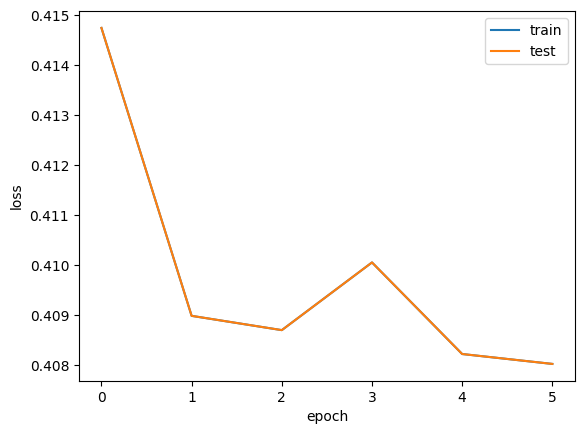

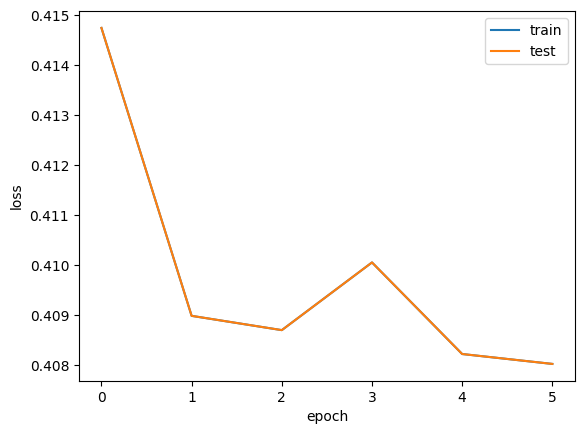

In [5]:
lr: float = 4e-2
n_epoch: int = 5
n_splits: int = 5
batch_size: int = 512
verbose: bool = True

optimizer.define_model()
optimizer.pretrain(verbose=False)
trainer = Trainer(
    dataset,
    dataset,
    optimizer.init_w,
    n_epoch=n_epoch,
    lr=lr,
    batch_size=batch_size,
)
optimizer.w = trainer.train(verbose=verbose)
trainer.plot()

  0%|          | 0/247973 [00:00<?, ?it/s]

Loss before training: 0.4272
Loss after training: 0.4122
RMSE(bins): 0.0351

Last rating: 1
RMSE(bins): 0.0543

Last rating: 2
RMSE(bins): 0.0420

Last rating: 3
RMSE(bins): 0.0367

Last rating: 4
RMSE(bins): 0.0382


{'all': {'R-squared': 0.8497472756316181,
  'MAE': 0.025293863600057455,
  'ICI': 0.02270097005608852,
  'E50': 0.01485958123745923,
  'E90': 0.04490653807310119,
  'EMax': 0.31915363770361593,
  'RMSE(bins)': 0.0351311125568909,
  'AUC': 0.6980245347084744},
 1: {'R-squared': 0.6103917907425835,
  'MAE': 0.05534066220490922,
  'ICI': 0.052640416339971983,
  'E50': 0.0519110040558739,
  'E90': 0.08389403949789977,
  'EMax': 0.2728403030145799,
  'RMSE(bins)': 0.054347101862990195,
  'AUC': 0.6704374726701875},
 2: {'R-squared': 0.786029786511139,
  'MAE': 0.03690796399389331,
  'ICI': 0.03285946197974652,
  'E50': 0.030902932447697484,
  'E90': 0.037820998149675364,
  'EMax': 0.3188202913040421,
  'RMSE(bins)': 0.04199459930690328,
  'AUC': 0.6771672885193358},
 3: {'R-squared': 0.8485511671449204,
  'MAE': 0.018118338513401052,
  'ICI': 0.016245755956553334,
  'E50': 0.005492330694048586,
  'E90': 0.04646548994780568,
  'EMax': 0.2904517546199129,
  'RMSE(bins)': 0.03667661854302682,


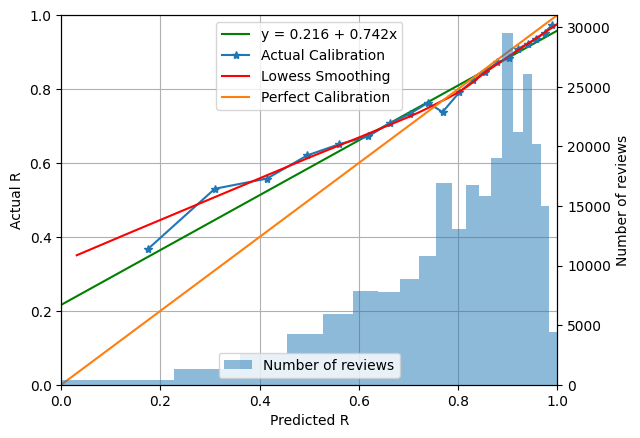

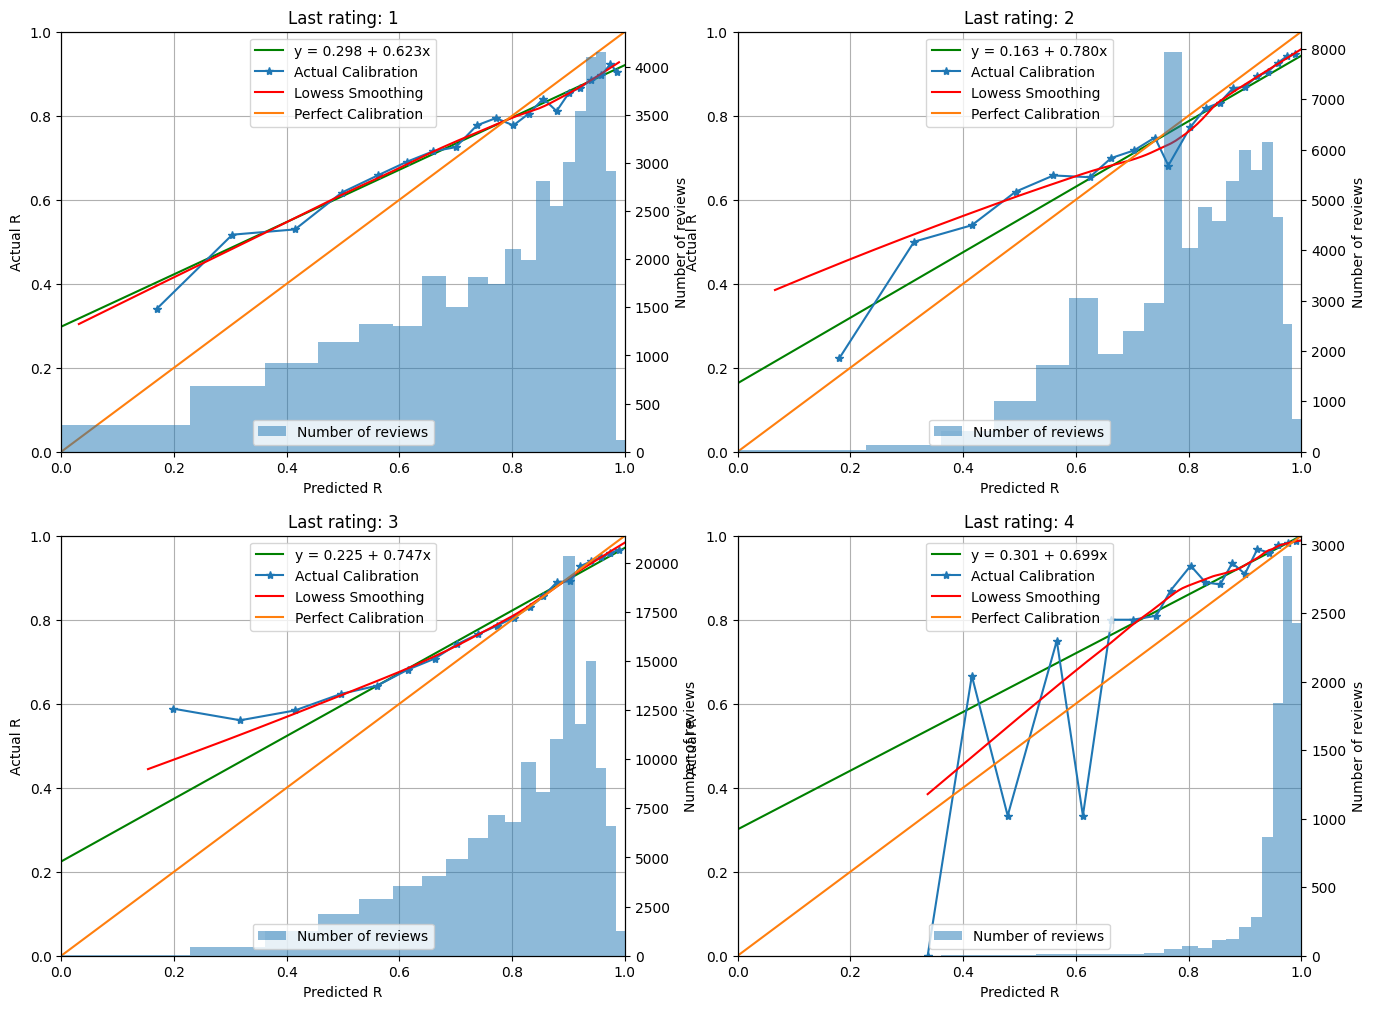

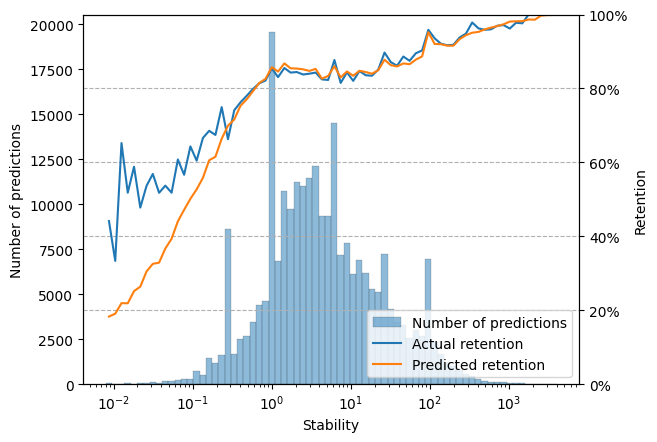

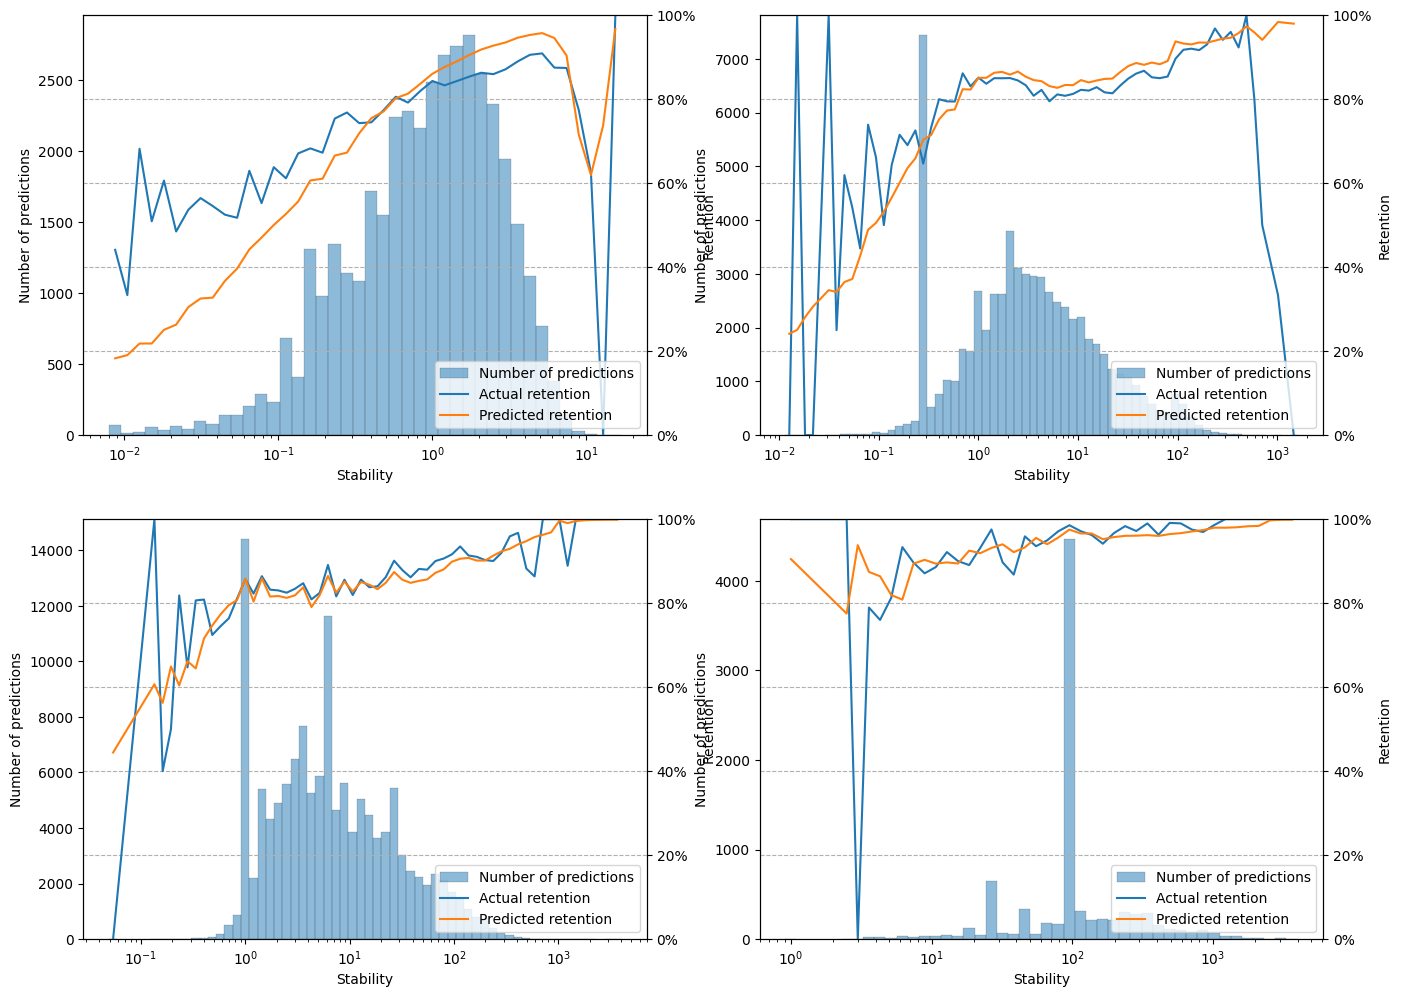

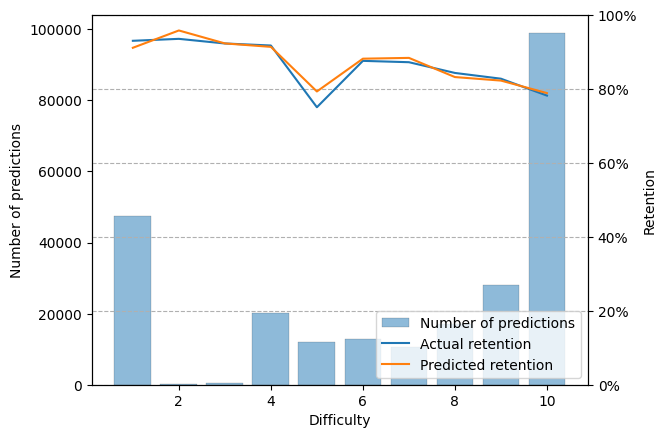

In [6]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")
metrics, figures = optimizer.calibration_graph()
metrics